### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *
import sqlite3
from sqlite3 import Error

In [3]:
database_dir = '/home/Assignment/02_training_pipeline/notebooks/'
#database_dir = root_dir + 'Data'

 ### 2 Reading Data

In [4]:
%%time
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
dataset = pd.read_csv('Data/cleaned_data.csv')

CPU times: user 276 ms, sys: 87.1 ms, total: 363 ms
Wall time: 361 ms


In [5]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [6]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [7]:
def create_sqlit_connection(db_path,db_file):
    """ create a database connection to a SQLite database """
    conn = None
    # opening the conncetion for creating the sqlite db
    try:
        conn = sqlite3.connect(db_path+db_file)
        print(sqlite3.version)
    # return an error if connection not established
    except Error as e:
        print(e)
    # closing the connection once the database is created
    finally:
        if conn:
            conn.close()

In [8]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebook/' location

create_sqlit_connection(database_dir, r"lead_scoring_model_experimentation.db")

2.6.0


In [9]:
# starting mlflow server
# mlflow server --backend-store-uri='sqlite:////home/Assignment/02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="/home/Assignment/mlruns/" --port=6007 --host=0.0.0.0

In [9]:
# create a mlflow tracking uri at "http://0.0.0.0:6007"
mlflow.set_tracking_uri("http://0.0.0.0:6007")

In [10]:
# setup pycaret 
# No Pre-Processing 
Baseline_model_exp01 = setup(data = dataset, target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=True,
                   log_experiment=True,experiment_name='Baseline_model_exp01',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 12)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


2022/11/01 18:33:57 INFO mlflow.tracking.fluent: Experiment with name 'Baseline_model_exp01' does not exist. Creating a new experiment.


### 4 : Model Experimentation with pycaret

In [11]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(fold = 5, exclude= ['gbc','knn','qda', 'dummy', 'svm', 'ada']) #

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7386,0.8211,0.8317,0.7029,0.7619,0.4766,0.4849,0.6860
lightgbm,Light Gradient Boosting Machine,0.7385,0.8211,0.8343,0.7020,0.7624,0.4765,0.4854,4.7720
et,Extra Trees Classifier,0.7367,0.8176,0.8210,0.7044,0.7582,0.4729,0.4797,4.4080
dt,Decision Tree Classifier,0.7364,0.8166,0.8205,0.7041,0.7579,0.4723,0.4789,0.6220
rf,Random Forest Classifier,0.7346,0.8169,0.8394,0.6957,0.7608,0.4686,0.4791,1.3840
lr,Logistic Regression,0.7098,0.7837,0.8222,0.6731,0.7402,0.4189,0.4297,0.4600
ridge,Ridge Classifier,0.7005,0.0000,0.7962,0.6702,0.7278,0.4003,0.4077,0.2320
lda,Linear Discriminant Analysis,0.7005,0.7733,0.7961,0.6702,0.7277,0.4003,0.4077,1.0300
nb,Naive Bayes,0.6629,0.7335,0.8924,0.6134,0.7269,0.3241,0.3653,0.2120


In [12]:
# create a model which gives the highest accuracy
lbgm  = create_model('lightgbm', fold = 5) 

In [13]:
lbgm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

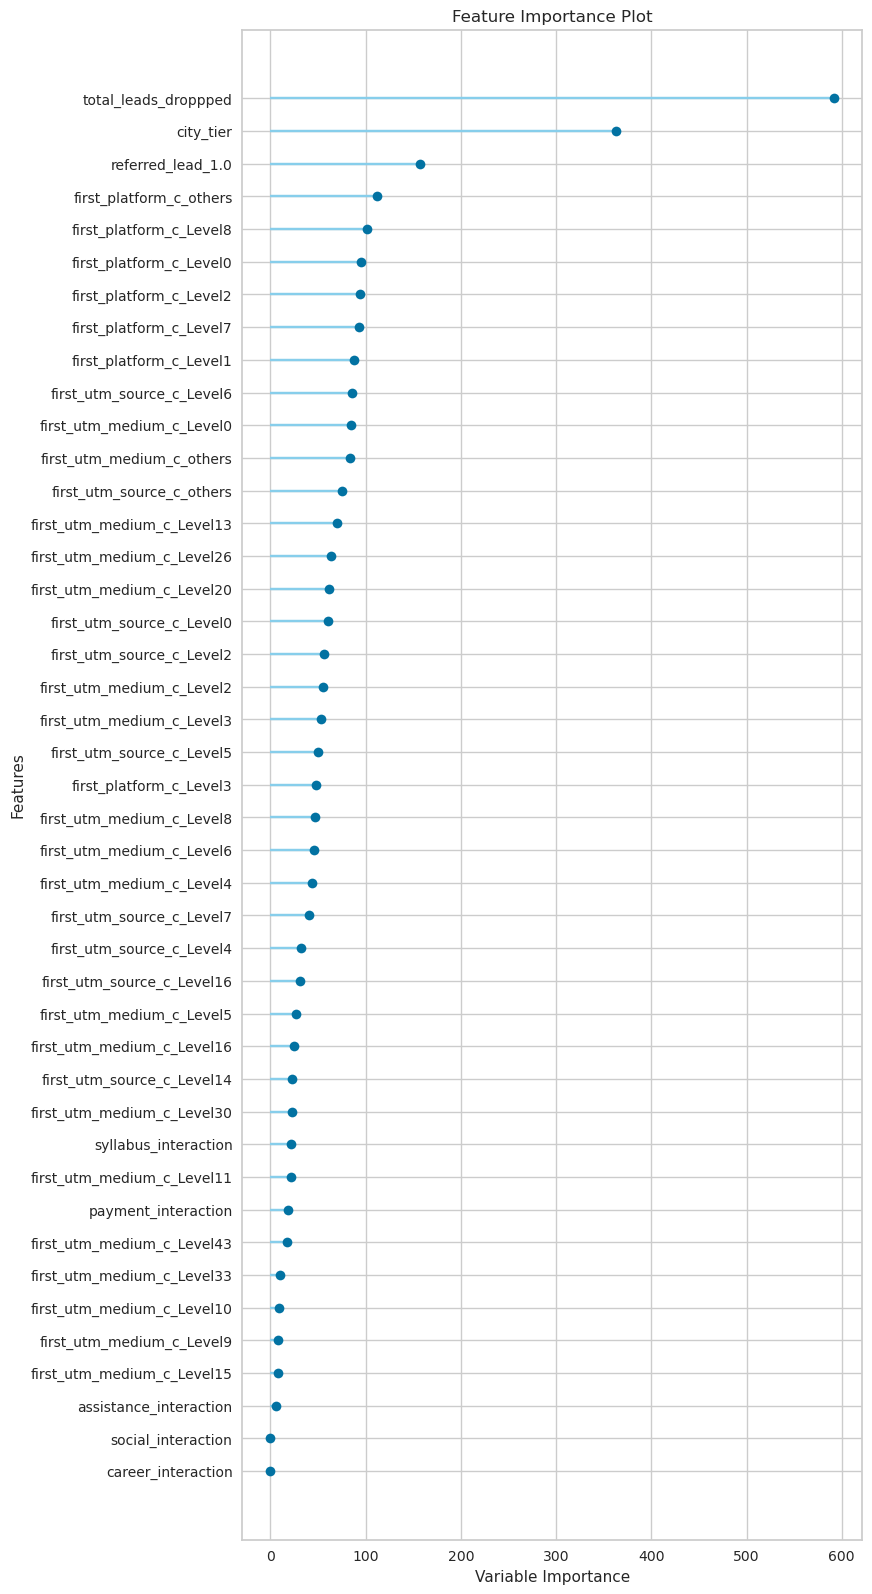

In [14]:
# create feature importance plot
#top 10 features
plot_model(lbgm, plot='feature_all') #feature_all -> to check for all features 

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [15]:
dataset_trimmed = dataset[['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']]

In [16]:
dataset_trimmed

,total_leads_droppped,city_tier,referred_lead,app_complete_flag,first_platform_c,first_utm_medium_c,first_utm_source_c
0,1.0,1.0,0.0,1,Level0,Level11,Level2
1,1.0,2.0,0.0,1,Level3,Level0,others
2,1.0,1.0,0.0,1,Level3,Level0,Level0
3,2.0,1.0,0.0,0,Level1,Level3,others
4,1.0,1.0,0.0,0,Level3,Level0,Level0
...,...,...,...,...,...,...,...
238959,1.0,1.0,0.0,1,Level3,Level0,Level0
238960,2.0,1.0,0.0,1,Level7,Level11,Level2
238961,2.0,2.0,0.0,1,Level0,Level4,Level2
238962,3.0,2.0,0.0,1,Level0,Level6,Level7


In [17]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.
Baseline_model_exp03 = setup(data = dataset_trimmed, target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=True,
                   log_experiment=True,experiment_name='Baseline_model_exp03',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False,
                   normalize = False ,  transformation = False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 7)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


2022/11/01 18:40:37 INFO mlflow.tracking.fluent: Experiment with name 'Baseline_model_exp03' does not exist. Creating a new experiment.


In [18]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
best_model = compare_models(fold = 5, exclude= ['gbc','knn','qda', 'dummy', 'svm', 'ada']) #

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7385,0.8210,0.8348,0.7018,0.7625,0.4765,0.4855,4.7560
xgboost,Extreme Gradient Boosting,0.7384,0.8209,0.8303,0.7031,0.7614,0.4762,0.4843,0.5980
et,Extra Trees Classifier,0.7366,0.8174,0.8211,0.7042,0.7582,0.4727,0.4795,3.8380
dt,Decision Tree Classifier,0.7363,0.8166,0.8205,0.7041,0.7578,0.4722,0.4788,0.5780
rf,Random Forest Classifier,0.7350,0.8178,0.8432,0.6949,0.7619,0.4693,0.4805,1.3720
lr,Logistic Regression,0.7097,0.7836,0.8221,0.6730,0.7401,0.4187,0.4295,0.2080
ridge,Ridge Classifier,0.7002,0.0000,0.7959,0.6700,0.7275,0.3998,0.4072,0.1760
lda,Linear Discriminant Analysis,0.7002,0.7726,0.7959,0.6700,0.7275,0.3998,0.4072,0.8920
nb,Naive Bayes,0.6701,0.7337,0.8568,0.6255,0.7231,0.3387,0.3650,0.2040


In [19]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret
# create a model which gives the highest accuracy
lbgm  = create_model('lightgbm', fold = 5) 

In [20]:
lbgm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [21]:
pip install optuna

  Using cached optuna-3.0.3-py3-none-any.whl (348 kB)
  Using cached scipy-1.8.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.6 MB)
  Using cached cmaes-0.8.2-py3-none-any.whl (15 kB)
  Using cached cliff-4.0.0-py3-none-any.whl (80 kB)
  Using cached autopage-0.5.1-py3-none-any.whl (29 kB)
  Using cached cmd2-2.4.2-py3-none-any.whl (147 kB)
  Using cached stevedore-4.1.0-py3-none-any.whl (50 kB)
  Using cached pyperclip-1.8.2-py3-none-any.whl
  Using cached pbr-5.11.0-py2.py3-none-any.whl (112 kB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.3
    Uninstalling scipy-1.5.3:
      Successfully uninstalled scipy-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires sklearn, which is not installed.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.22.2 which is incompatible.


In [22]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC
tuned_lgbm_optuna,tuner = tune_model(lbgm, 
                                    search_library='optuna',
                                    search_algorithm='random',
                                    fold = 10,
                                    optimize = 'AUC',
                                    choose_better=True,
                                    return_tuner=True)

In [23]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
print(tuner)

OptunaSearchCV(callbacks=None,
               cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
               enable_pruning=False, error_score='raise',
               estimator=Pipeline(memory=None,
                                  steps=[('empty_step', 'passthrough'),
                                         ('actual_estimator',
                                          LGBMClassifier(boosting_type='gbdt',
                                                         class_weight=None,
                                                         colsample_bytree=1.0,
                                                         device='gpu',
                                                         importance_type='split',
                                                         learning_rate=0....
                                    'actual_estimator__reg_alpha': FloatDistribution(high=10.0, log=True, low=1e-10, step=None),
                                    'actual_estimator__

In [24]:
print(tuned_lgbm_optuna)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
